In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm import tqdm
import wandb

# 207

In [18]:
class BigFiveDataset207(Dataset):
    def __init__(self, X, y, x_mean=None, x_std=None, y_mean=None, y_std=None, train=False):
        self.train = train

        velocity = np.diff(X, axis=1, prepend=X[:, :1, :])
        acceleration = np.diff(velocity, axis=1, prepend=velocity[:, :1, :])
        X_aug = np.concatenate([X, velocity, acceleration], axis=2)

        if x_mean is not None and x_std is not None:
            X_aug = (X_aug - x_mean) / (x_std + 1e-6)
        if y_mean is not None and y_std is not None:
            y = (y - y_mean) / (y_std + 1e-6)

        self.X = torch.tensor(X_aug, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]

        if self.train:
            if torch.rand(1) > 0.5:
                x = torch.flip(x, dims=[0])
            if torch.rand(1) > 0.8:
                noise = torch.randn_like(x) * 0.01
                x = x + noise

        return x, y


# def remove_leg_channels(X):
#     leg_indices = list(range(23, 33))
#     mask = np.ones(X.shape[2], dtype=bool)
#     mask[leg_indices] = False
#     return X[:, :, mask]

def remove_leg_channels(X):
    # Индексы суставов с 23 по 32 включительно
    leg_joint_indices = list(range(23, 33))  # 10 суставов

    # Вычисляем соответствующие индексы координат (x, y, z) каждого сустава
    leg_channel_indices = []
    for joint in leg_joint_indices:
        leg_channel_indices.extend([joint * 3, joint * 3 + 1, joint * 3 + 2])

    # Создаём маску для удаления этих каналов
    mask = np.ones(X.shape[2], dtype=bool)
    mask[leg_channel_indices] = False

    return X[:, :, mask]

def prepare_datasets207(train_path, test_path):
    train_data = np.load(train_path)
    test_data = np.load(test_path)

    X_train = remove_leg_channels(train_data['X'])
    y_train = train_data['y']
    X_test = remove_leg_channels(test_data['X'])
    y_test = test_data['y']

    # Расчёт расширенных признаков внутри BigFiveDataset, но
    # для статистик надо сначала посчитать X_aug для train
    # Для этого временно создаём BigFiveDataset без нормализации и без train-а
    temp_dataset = BigFiveDataset207(X_train, y_train, train=False)
    X_aug_train = temp_dataset.X.numpy()

    # Считаем статистики по тренировочным данным
    x_mean = X_aug_train.mean(axis=(0,1), keepdims=True)
    x_std = X_aug_train.std(axis=(0,1), keepdims=True)
    y_mean = y_train.mean(axis=0, keepdims=True)
    y_std = y_train.std(axis=0, keepdims=True)

    # Создаём окончательные датасеты с нормализацией и аугментацией
    train_dataset = BigFiveDataset207(X_train, y_train, x_mean, x_std, y_mean, y_std, train=True)
    val_dataset = BigFiveDataset207(X_test, y_test, x_mean, x_std, y_mean, y_std, train=False)

    return train_dataset, val_dataset, y_mean, y_std

In [20]:
def generate_simple_feature_names(num_joints=23):
    feature_names = []

    # 1. Исходные координаты: x_j0, y_j0, z_j0, ..., x_j22, y_j22, z_j22
    for j in range(num_joints):
        feature_names += [f'x_{j}', f'y_{j}', f'z_{j}']

    # 2. Скорость: vx_j0, vy_j0, vz_j0, ..., vx_j22, ...
    for j in range(num_joints):
        feature_names += [f'vx_{j}', f'vy_{j}', f'vz_{j}']

    # 3. Ускорение: ax_j0, ay_j0, az_j0, ..., ax_j22, ...
    for j in range(num_joints):
        feature_names += [f'ax_{j}', f'ay_{j}', f'az_{j}']

    return feature_names

# Генерируем имена фичей
feature_names = generate_simple_feature_names()

# Вывод количества и первых 10 фичей
print(f"Количество фичей: {len(feature_names)}")
print("Первые 10 фичей:")
print(feature_names[:10])

Количество фичей: 207
Первые 10 фичей:
['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2', 'x_3']


# 290

In [21]:
class BigFiveDataset290(Dataset):
    def __init__(self, X, y, x_mean=None, x_std=None, y_mean=None, y_std=None, train=False):
        self.train = train

        # Базовые динамические признаки
        velocity = np.diff(X, axis=1, prepend=X[:, :1, :])
        acceleration = np.diff(velocity, axis=1, prepend=velocity[:, :1, :])

        # Расширенные признаки
        jerk = np.diff(acceleration, axis=1, prepend=acceleration[:, :1, :])  # (N, T, C)
        jerk_rms = np.sqrt(np.mean(jerk ** 2, axis=(1, 2), keepdims=True))  # (N, 1, 1)
        kinetic_energy = np.sum(velocity ** 2, axis=2, keepdims=True)  # (N, T, 1)
        smoothness = 1.0 / (np.sum(np.abs(jerk), axis=(1, 2), keepdims=True) + 1e-6)  # (N, 1, 1)

        jerk_rms_rep = np.repeat(jerk_rms, X.shape[1], axis=1)  # (N, T, 1)
        kinetic_rep = kinetic_energy  # уже (N, T, 1)
        smoothness_rep = np.repeat(smoothness, X.shape[1], axis=1)  # (N, T, 1)

        # Парные расстояния
        def pairwise_distance(X, i, j):
            xi = X[:, :, i*3:(i+1)*3]
            xj = X[:, :, j*3:(j+1)*3]
            return np.linalg.norm(xi - xj, axis=2, keepdims=True)  # (N, T, 1)

        wrist_dist = pairwise_distance(X, 15, 20)
        elbow_dist = pairwise_distance(X, 13, 18)
        knee_dist = pairwise_distance(X, 26, 31)

        # Симметрия (разность левых и правых точек)
        def compute_symmetry(X, left_idxs, right_idxs):
            diffs = []
            for l, r in zip(left_idxs, right_idxs):
                left = X[:, :, l*3:(l+1)*3]
                right = X[:, :, r*3:(r+1)*3]
                diffs.append(np.abs(left - right))
            return np.concatenate(diffs, axis=2)  # (N, T, 3 * num_pairs)

        symmetry = compute_symmetry(X, [15, 13, 26], [20, 18, 31])  # (N, T, 9)

        # Углы суставов
        def compute_joint_angles(X, a, b, c):
            A = X[:, :, a*3:(a+1)*3]
            B = X[:, :, b*3:(b+1)*3]
            C = X[:, :, c*3:(c+1)*3]

            BA = A - B
            BC = C - B

            dot = np.sum(BA * BC, axis=2)
            norm_product = np.linalg.norm(BA, axis=2) * np.linalg.norm(BC, axis=2)
            cos_angle = np.clip(dot / (norm_product + 1e-6), -1.0, 1.0)
            angle = np.arccos(cos_angle)  # в радианах
            return angle[:, :, np.newaxis]  # (N, T, 1)

        left_elbow_angle = compute_joint_angles(X, 11, 13, 15)
        right_elbow_angle = compute_joint_angles(X, 16, 18, 20)

        # Финальный тензор признаков
        X_aug = np.concatenate([
            X, velocity, acceleration, jerk,
            jerk_rms_rep, kinetic_rep, smoothness_rep,
            wrist_dist, elbow_dist, knee_dist,
            symmetry, left_elbow_angle, right_elbow_angle
        ], axis=2)

        # Нормализация
        if x_mean is not None and x_std is not None:
            X_aug = (X_aug - x_mean) / (x_std + 1e-6)
        if y_mean is not None and y_std is not None:
            y = (y - y_mean) / (y_std + 1e-6)

        self.X = torch.tensor(X_aug, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]

        if self.train:
            if torch.rand(1) > 0.5:
                x = torch.flip(x, dims=[0])
            if torch.rand(1) > 0.8:
                noise = torch.randn_like(x) * 0.01
                x = x + noise

        return x, y
        
def prepare_datasets290(train_path, test_path):
    train_data = np.load(train_path)
    test_data = np.load(test_path)

    X_train = remove_leg_channels(train_data['X'])
    y_train = train_data['y']
    X_test = remove_leg_channels(test_data['X'])
    y_test = test_data['y']

    # Сначала считаем X_aug без нормализации
    temp_dataset = BigFiveDataset290(X_train, y_train, train=False)
    X_aug_train = temp_dataset.X.numpy()

    # Статистики
    x_mean = X_aug_train.mean(axis=(0, 1), keepdims=True)
    x_std = X_aug_train.std(axis=(0, 1), keepdims=True)
    y_mean = y_train.mean(axis=0, keepdims=True)
    y_std = y_train.std(axis=0, keepdims=True)

    # Нормализованные датасеты
    train_dataset = BigFiveDataset290(X_train, y_train, x_mean, x_std, y_mean, y_std, train=True)
    val_dataset = BigFiveDataset290(X_test, y_test, x_mean, x_std, y_mean, y_std, train=False)

    return train_dataset, val_dataset, y_mean, y_std




In [22]:
def remove_leg_channels(X):
    # Индексы суставов с 23 по 32 включительно
    leg_joint_indices = list(range(23, 33))  # 10 суставов

    # Вычисляем соответствующие индексы координат (x, y, z) каждого сустава
    leg_channel_indices = []
    for joint in leg_joint_indices:
        leg_channel_indices.extend([joint * 3, joint * 3 + 1, joint * 3 + 2])

    # Создаём маску для удаления этих каналов
    mask = np.ones(X.shape[2], dtype=bool)
    mask[leg_channel_indices] = False

    return X[:, :, mask]


In [23]:
def generate_feature_names290(num_joints=23):
    feature_names = []

    # Список точек, которые мы оставляем (0–22)
    joints = list(range(num_joints))  # от 0 до 22

    # 1. Исходные координаты: x_j0, y_j0, z_j0, ..., x_j22, y_j22, z_j22
    for j in joints:
        feature_names += [f'x_{j}', f'y_{j}', f'z_{j}']

    # 2. Скорость: vx_j0, vy_j0, vz_j0, ...
    for j in joints:
        feature_names += [f'vx_{j}', f'vy_{j}', f'vz_{j}']

    # 3. Ускорение: ax_j0, ay_j0, az_j0, ...
    for j in joints:
        feature_names += [f'ax_{j}', f'ay_{j}', f'az_{j}']

    # 4. Джерк / рывок: jx_j0, jy_j0, jz_j0, ...
    for j in joints:
        feature_names += [f'jx_{j}', f'jy_{j}', f'jz_{j}']

    # 5. Глобальные статистики (повторяются по времени)
    feature_names += ['jerk_rms']
    feature_names += ['kinetic_energy']
    feature_names += ['smoothness']

    # 6. Парные расстояния (между ключевыми точками)
    feature_names += ['wrist_distance']   # между j15 и j20
    feature_names += ['elbow_distance']   # между j13 и j18
    feature_names += ['knee_distance']    # между j26 и j31 — но они удалены

    # 7. Симметрия между левой и правой стороной
    symmetry_pairs = [(15, 20), (13, 18)]  # j26 и j31 уже нет
    for l, r in symmetry_pairs:
        feature_names += [f'symmetry_{l}_{r}_dx', f'symmetry_{l}_{r}_dy', f'symmetry_{l}_{r}_dz']

    # 8. Углы суставов
    feature_names += ['left_elbow_angle_rad']   # между j11, j13, j15
    feature_names += ['right_elbow_angle_rad']  # между j16, j18, j20

    return feature_names

# Создаём список имён фичей
feature_names = generate_feature_names290()

# Вывод количества и первых фичей
print(f"Количество фичей: {len(feature_names)}")
print("Первые 10 фичей:")
print(feature_names[:10])

Количество фичей: 290
Первые 10 фичей:
['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2', 'x_3']


In [8]:
train_path, test_path = "/Users/egor/Documents/STUDY/НИР/data/train.npz", "/Users/egor/Documents/STUDY/НИР/data/test.npz"

In [13]:
train_dataset, val_dataset, y_mean, y_std = prepare_datasets290(train_path, test_path)
train_dataset[0][0].shape

torch.Size([459, 290])

# Обучение моделей

In [39]:
def train_and_evaluate(model, train_loader, val_loader, y_mean, y_std, device, traits, num_epochs=50, patience=7):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = nn.SmoothL1Loss()
    # criterion = HybridLoss()
    best_val_rmse = float('inf')
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_losses.append(loss.item())

        val_preds, val_targets = evaluate(model, val_loader, y_mean, y_std, device)
        val_rmse = np.sqrt(np.mean((val_preds - val_targets) ** 2))
        scheduler.step(val_rmse)

        print(f"Epoch {epoch+1} | Train loss: {np.mean(epoch_losses):.4f} | Val RMSE: {val_rmse:.4f}")
        for i, trait in enumerate(traits):
            r2 = r2_score(val_targets[:, i], val_preds[:, i])
            mae = mean_absolute_error(val_targets[:, i], val_preds[:, i])
            print(f"  {trait}: R²={r2:.3f}, MAE={mae:.3f}")

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': np.mean(epoch_losses),
            'val_rmse': val_rmse,
            **{f'{trait}/r2': r2_score(val_targets[:, i], val_preds[:, i]) for i, trait in enumerate(traits)},
            **{f'{trait}/mae': mean_absolute_error(val_targets[:, i], val_preds[:, i]) for i, trait in enumerate(traits)},
            **{f'{trait}/ccc': concordance_correlation_coefficient(val_targets[:, i], val_preds[:, i]) for i, trait in enumerate(traits)},
            **{f'{trait}/pcc': pearson_correlation_coefficient(val_targets[:, i], val_preds[:, i]) for i, trait in enumerate(traits)},
        })

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"  Best model saved! Val RMSE: {val_rmse:.4f}")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    model.load_state_dict(torch.load('best_model.pth'))
    final_preds, final_targets = evaluate(model, val_loader, y_mean, y_std, device)

    results = {
        'overall_rmse': np.sqrt(np.mean((final_preds - final_targets) ** 2)),
        'traits': {}
    }

    print("\nFinal Evaluation:")
    print(f"Overall RMSE: {results['overall_rmse']:.4f}")
    for i, trait in enumerate(traits):
        y_true = final_targets[:, i]
        y_pred = final_preds[:, i]
        r2 = r2_score(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        ccc = concordance_correlation_coefficient(y_true, y_pred)
        pcc = pearson_correlation_coefficient(y_true, y_pred)
    
        results['traits'][trait] = {
            'r2': r2,
            'mae': mae,
            'ccc': ccc,
            'pcc': pcc
        }
    
        print(f"  {trait}: R²={r2:.3f}, MAE={mae:.3f}, CCC={ccc:.3f}, PCC={pcc:.3f}")

    return results

def evaluate(model, loader, y_mean, y_std, device):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())

    preds = np.vstack(all_preds) * y_std + y_mean
    targets = np.vstack(all_targets) * y_std + y_mean

    return preds, targets



# Дополнительные функции (метрики и тд)

In [42]:
def concordance_correlation_coefficient(y_true, y_pred):

    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))

    ccc = (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred) ** 2 + 1e-8)
    return ccc
    
class HybridLoss(nn.Module):
    def __init__(self):
        super(HybridLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()

    def forward(self, outputs, targets):
        loss = self.mse(outputs, targets) + self.mae(outputs, targets)
        return loss


def pearson_correlation_coefficient(y_true, y_pred):
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()
    
    y_true_mean = np.mean(y_true)
    y_pred_mean = np.mean(y_pred)
    
    numerator = np.sum((y_true - y_true_mean) * (y_pred - y_pred_mean))
    denominator = np.sqrt(np.sum((y_true - y_true_mean) ** 2) * np.sum((y_pred - y_pred_mean) ** 2))
    
    return numerator / (denominator + 1e-8)

def concordance_correlation_coefficient(y_true, y_pred):

    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    covariance = np.mean((y_true - mean_true) * (y_pred - mean_pred))

    ccc = (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred) ** 2 + 1e-8)
    return ccc


# Функция по созданию обучения с нужной моделью и датасетом

In [62]:
def run_experiment(train_path, test_path, model_class, model_params, traits, feature_numbers):
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    wandb.init(
        project="BigFive-TCN",
        name="TCN_run",
        config=model_params,
        reinit=True
    )

    wandb.config.update({
        'train_path': train_path,
        'test_path': test_path,
        'model_class': model_class.__name__,
        'traits': traits,
    })
    if feature_numbers == 290:
        train_dataset, val_dataset, y_mean, y_std = prepare_datasets290(train_path, test_path)
    elif feature_numbers == 207:
        train_dataset, val_dataset, y_mean, y_std = prepare_datasets207(train_path, test_path)
    else:
        raise ValueError(f"Unsupported feature_number: {feature_number}. "
                     "Supported values are 290 and 207.")
        
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    model = model_class(**model_params).to(device)
    results = train_and_evaluate(model, train_loader, val_loader, y_mean, y_std, device, traits)

    wandb.finish()
    return results, model

import torch.nn as nn



# TCN  

In [37]:
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding='same', dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding='same', dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.bn_down = nn.BatchNorm1d(out_channels) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        if self.downsample is not None:
            residual = self.downsample(residual)
            residual = self.bn_down(residual)

        return F.relu(out + residual)

class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=5, dropout=0.3):
        super().__init__()
        layers = []
        num_levels = len(num_channels)

        for i in range(num_levels):
            dilation_size = 2 ** i
            in_ch = input_size if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            layers += [TemporalBlock(in_ch, out_ch, kernel_size, dilation_size, dropout)]

        self.network = nn.Sequential(*layers)
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(num_channels[-1], 32),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(32, 1)
            ) for _ in range(output_size)
        ])

    def forward(self, x):
        x = x.transpose(1, 2)
        out = self.network(x)
        out = out.mean(dim=2)

        outputs = [head(out) for head in self.heads]
        return torch.cat(outputs, dim=1)

# Конфигурация модели (для данных с 207 признаками)

In [63]:

TRAIN_PATH = '/Users/egor/Documents/STUDY/НИР/data/train.npz'
TEST_PATH = '/Users/egor/Documents/STUDY/НИР/data/test.npz'
TRAITS = ['EXTRAVERSION', 'AGREEABLENESS', 'CONSCIENTIOUSNESS', 'NEUROTICISM', 'OPENNESS']


feature_numbers = 207
MODEL_CONFIGS = {
    'TCN_large': {
        'class': TCN,
        'params': {
            'input_size': feature_numbers,
            'output_size': 5,
            'num_channels': [128, 128, 128, 128],
            'kernel_size': 5,
            'dropout': 0.3
        }
    }
}

all_results = {}
for model_name, config in MODEL_CONFIGS.items():
    print(f"\n=== Training {model_name} ===")
    results, model = run_experiment(
        TRAIN_PATH, TEST_PATH,
        config['class'], config['params'],
        TRAITS, 
        feature_numbers
    )
    all_results[model_name] = results

print("\n=== Model Comparison ===")
for model_name, results in all_results.items():
    print(f"\n{model_name}:")
    print(f"Overall RMSE: {results['overall_rmse']:.4f}")
    for trait in TRAITS:
        print(f"  {trait}: R²={results['traits'][trait]['r2']:.3f}, MAE={results['traits'][trait]['mae']:.3f}")


=== Training TCN_large ===
Using device: mps


Epoch 1 | Train loss: 0.4187 | Val RMSE: 0.1403
  EXTRAVERSION: R²=0.054, MAE=0.117
  AGREEABLENESS: R²=0.044, MAE=0.102
  CONSCIENTIOUSNESS: R²=0.054, MAE=0.121
  NEUROTICISM: R²=0.068, MAE=0.117
  OPENNESS: R²=0.068, MAE=0.111
  Best model saved! Val RMSE: 0.1403
Epoch 2 | Train loss: 0.4034 | Val RMSE: 0.1381
  EXTRAVERSION: R²=0.102, MAE=0.113
  AGREEABLENESS: R²=0.070, MAE=0.101
  CONSCIENTIOUSNESS: R²=0.091, MAE=0.118
  NEUROTICISM: R²=0.087, MAE=0.116
  OPENNESS: R²=0.078, MAE=0.110
  Best model saved! Val RMSE: 0.1381
Epoch 3 | Train loss: 0.3970 | Val RMSE: 0.1380
  EXTRAVERSION: R²=0.092, MAE=0.114
  AGREEABLENESS: R²=0.059, MAE=0.101
  CONSCIENTIOUSNESS: R²=0.096, MAE=0.117
  NEUROTICISM: R²=0.082, MAE=0.115
  OPENNESS: R²=0.106, MAE=0.107
  Best model saved! Val RMSE: 0.1380
Epoch 4 | Train loss: 0.3931 | Val RMSE: 0.1352
  EXTRAVERSION: R²=0.146, MAE=0.111
  AGREEABLENESS: R²=0.089, MAE=0.100
  CONSCIENTIOUSNESS: R²=0.101, MAE=0.118
  NEUROTICISM: R²=0.126, MAE=0.114
  OPE

AGREEABLENESS/ccc,▁▂▃▄▅▅▄▆▅▄▃▅▅▆▅▄▆▇▇▇▇██▇█▇██
AGREEABLENESS/mae,█▆▆▅▄▄▃▂▃▄▄▂▂▃▂▄▂▂▂▂▁▃▂▁▃▁▂▄
AGREEABLENESS/pcc,▁▃▄▅▆▆▇▇▇▇▆█▇▆▇▅█▇▇▇███████▇
AGREEABLENESS/r2,▁▃▂▄▆▆▇▇▇▅▅▇▇▆▇▅█▇▇▇█▅▆█▆█▆▄
CONSCIENTIOUSNESS/ccc,▁▃▃▃▅▅▅▆▅▅▅▅▆▆▆▅▇▇▇▇▇█▇▇████
CONSCIENTIOUSNESS/mae,█▆▅▆▄▄▃▄▃▃▄▂▂▃▃▄▁▂▂▂▁▂▁▁▂▁▁▃
CONSCIENTIOUSNESS/pcc,▁▃▄▄▅▅▆▆▆▆▅▇▇▆▆▅▇▇▇▇███▇▇██▇
CONSCIENTIOUSNESS/r2,▁▃▃▄▅▅▆▅▇▆▆█▇▆▆▄█▇▇▇█▇▇█▆█▇▅
EXTRAVERSION/ccc,▁▃▃▄▅▅▅▅▆▄▄▆▆▇▇▅▇▇█▇▇▇▇▇▇▇██
EXTRAVERSION/mae,█▆▆▄▄▃▄▂▃▄▄▂▂▂▂▃▁▂▁▂▁▂▂▂▂▁▂▃
EXTRAVERSION/pcc,▁▄▅▆▆▆▇▇▇▇▇█▇█▇▇█▇██████▇██▇



=== Model Comparison ===

TCN_large:
Overall RMSE: 0.1299
  EXTRAVERSION: R²=0.207, MAE=0.105
  AGREEABLENESS: R²=0.135, MAE=0.097
  CONSCIENTIOUSNESS: R²=0.175, MAE=0.111
  NEUROTICISM: R²=0.204, MAE=0.109
  OPENNESS: R²=0.230, MAE=0.099


# Конфигурация модели (для данных с 297 признаками)

In [45]:

TRAIN_PATH = '/Users/egor/Documents/STUDY/НИР/data/train.npz'
TEST_PATH = '/Users/egor/Documents/STUDY/НИР/data/test.npz'
TRAITS = ['EXTRAVERSION', 'AGREEABLENESS', 'CONSCIENTIOUSNESS', 'NEUROTICISM', 'OPENNESS']


feature_numbers = 290
MODEL_CONFIGS = {
    'TCN_large': {
        'class': TCN,
        'params': {
            'input_size': feature_numbers,
            'output_size': 5,
            'num_channels': [128, 128, 128, 128],
            'kernel_size': 5,
            'dropout': 0.3
        }
    }
}

all_results = {}
for model_name, config in MODEL_CONFIGS.items():
    print(f"\n=== Training {model_name} ===")
    results, model = run_experiment(
        TRAIN_PATH, TEST_PATH,
        config['class'], config['params'],
        TRAITS, 
        feature_numbers
    )
    all_results[model_name] = results

print("\n=== Model Comparison ===")
for model_name, results in all_results.items():
    print(f"\n{model_name}:")
    print(f"Overall RMSE: {results['overall_rmse']:.4f}")
    for trait in TRAITS:
        print(f"  {trait}: R²={results['traits'][trait]['r2']:.3f}, MAE={results['traits'][trait]['mae']:.3f}")


=== Training TCN_large ===
Using device: mps


Epoch 1 | Train loss: 0.4144 | Val RMSE: 0.1373
  EXTRAVERSION: R²=0.113, MAE=0.113
  AGREEABLENESS: R²=0.067, MAE=0.101
  CONSCIENTIOUSNESS: R²=0.079, MAE=0.118
  NEUROTICISM: R²=0.106, MAE=0.115
  OPENNESS: R²=0.116, MAE=0.108
  Best model saved! Val RMSE: 0.1373
Epoch 2 | Train loss: 0.3942 | Val RMSE: 0.1385
  EXTRAVERSION: R²=0.108, MAE=0.113
  AGREEABLENESS: R²=0.056, MAE=0.101
  CONSCIENTIOUSNESS: R²=0.082, MAE=0.117
  NEUROTICISM: R²=0.070, MAE=0.116
  OPENNESS: R²=0.089, MAE=0.109
Epoch 3 | Train loss: 0.3907 | Val RMSE: 0.1361
  EXTRAVERSION: R²=0.127, MAE=0.112
  AGREEABLENESS: R²=0.086, MAE=0.100
  CONSCIENTIOUSNESS: R²=0.108, MAE=0.116
  NEUROTICISM: R²=0.108, MAE=0.114
  OPENNESS: R²=0.131, MAE=0.106
  Best model saved! Val RMSE: 0.1361
Epoch 4 | Train loss: 0.3862 | Val RMSE: 0.1352
  EXTRAVERSION: R²=0.133, MAE=0.111
  AGREEABLENESS: R²=0.096, MAE=0.099
  CONSCIENTIOUSNESS: R²=0.121, MAE=0.116
  NEUROTICISM: R²=0.126, MAE=0.114
  OPENNESS: R²=0.145, MAE=0.106
  Best mod

AGREEABLENESS/ccc,▁▁▂▃▃▅▃▄▄▅▅▇▅▆▅▆▆▆▆▆▆▆██
AGREEABLENESS/mae,██▆▄▄▃▅▄▃▄▂▃▁▃▃▂▁▂▁▂▂▁▁▄
AGREEABLENESS/pcc,▁▃▅▅▆▆▅▆▆▆▇▇█▇▆▆█▇▇▇▆▇█▇
AGREEABLENESS/r2,▂▁▄▅▆▆▅▆▆▆▇▆█▇▆▇█▇▇▇▅▇▇▅
CONSCIENTIOUSNESS/ccc,▁▃▂▃▂▄▃▄▄▅▆▅▆▅▆▆█▆▇▅▆▆██
CONSCIENTIOUSNESS/mae,█▇▆▆▇▄▅▄▄▅▄▄▃▃▄▃▁▂▂▃▃▂▃▃
CONSCIENTIOUSNESS/pcc,▁▄▄▅▄▅▅▆▅▅▆▅▇▆▆▇█▇▇▇▆▇██
CONSCIENTIOUSNESS/r2,▁▁▃▅▃▅▅▆▅▅▅▅▇▇▅▆█▇▇▇▆▇▅▇
EXTRAVERSION/ccc,▂▃▁▂▃▄▄▅▄▆▆▆▄▅▅▆▇▆▆▆▆▅▇█
EXTRAVERSION/mae,██▇▆▅▅▅▄▄▂▂▃▃▄▄▂▁▂▂▂▃▃▁▂
EXTRAVERSION/pcc,▁▃▃▃▄▄▅▅▅▇▇▆▇▆▆▇█▇▇▇▇▇██



=== Model Comparison ===

TCN_large:
Overall RMSE: 0.1309
  EXTRAVERSION: R²=0.204, MAE=0.106
  AGREEABLENESS: R²=0.126, MAE=0.098
  CONSCIENTIOUSNESS: R²=0.162, MAE=0.111
  NEUROTICISM: R²=0.187, MAE=0.109
  OPENNESS: R²=0.214, MAE=0.101


# Shap анализ + важность признаков 

In [77]:
# model

In [ ]:
import torch
import shap
import numpy as np
from tqdm import tqdm

# Выбираем устройство: MPS (Apple GPU), CUDA или CPU
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")

device = torch.device('cpu')
print(f"Using device: {device}")

# Предполагается, что tcn_model — ваша обученная модель
model.to(device)
model.eval()

for m in model.modules():
    if isinstance(m, torch.nn.Dropout):
        m.p = 0.0

# Получаем фон для explainer (примерно 100 примеров из train_dataset)
background_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
background = next(iter(background_loader))[0].to(device)  # Берём только X

# Данные для оценки SHAP (первые 32 из val_dataset)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Создаем SHAP DeepExplainer с моделью и фоном
explainer = shap.DeepExplainer(model, background)

all_shap_values = []

print("Calculating SHAP values...")
for batch in tqdm(test_loader):
    batch_x = batch[0].to(device)  # берем только X, переводим на device
    shap_vals = explainer.shap_values(batch_x)
    # shap_vals может быть list (multiclass) или ndarray
    # Переносим на CPU для экономии памяти
    if isinstance(shap_vals, list):
        shap_vals = [val.cpu().numpy() for val in shap_vals]
    else:
        shap_vals = shap_vals.cpu().numpy()
    all_shap_values.append(shap_vals)

# Объединяем батчи
if isinstance(all_shap_values[0], list):
    combined_shap = []
    for i in range(len(all_shap_values[0])):
        combined_shap.append(np.concatenate([batch[i] for batch in all_shap_values], axis=0))
else:
    combined_shap = np.concatenate(all_shap_values, axis=0)

print(f"Combined SHAP values shape: {np.array(combined_shap).shape}")

# Усредняем по сэмплам и времени
if isinstance(combined_shap, list):
    for i, shap_arr in enumerate(combined_shap):
        mean_shap = np.mean(np.abs(shap_arr), axis=(0,1))
        print(f"Mean SHAP values per feature for output {i}:", mean_shap)
else:
    mean_shap = np.mean(np.abs(combined_shap), axis=(0,1))
    print("Mean SHAP values per feature:", mean_shap)


In [57]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error  # замените на нужную метрику

def permutation_importance(model, X_val, y_val, metric=mean_squared_error, device='cpu'):
    """
    Вычисляет важность признаков методом перестановок.

    Args:
        model: обученная PyTorch модель.
        X_val: тензор с валидационными данными, shape (batch, seq_len, features).
        y_val: тензор с истинными метками, shape (batch, output_size).
        metric: функция ошибки, принимает (y_true, y_pred) и возвращает число (чем меньше — тем лучше).
        device: устройство ('cpu' или 'cuda' и т.п.).

    Returns:
        importances: список значений важности для каждого признака.
    """

    model.eval()
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    # Предсказание на оригинальных данных
    with torch.no_grad():
        base_pred = model(X_val).cpu().numpy()

    base_score = metric(y_val.cpu().numpy(), base_pred)

    importances = []
    X_val_np = X_val.cpu().numpy()

    for i in range(X_val_np.shape[-1]):  # перебираем признаки
        X_val_permuted = X_val_np.copy()

        # Перемешиваем значения признака i по всему батчу и всем временным шагам
        # Перемешивание делаем по элементам по оси (batch*seq_len)
        flattened = X_val_permuted[:, :, i].flatten()
        np.random.shuffle(flattened)
        X_val_permuted[:, :, i] = flattened.reshape(X_val_permuted.shape[0], X_val_permuted.shape[1])

        X_val_perm_tensor = torch.tensor(X_val_permuted).float().to(device)

        with torch.no_grad():
            perm_pred = model(X_val_perm_tensor).cpu().numpy()

        perm_score = metric(y_val.cpu().numpy(), perm_pred)

        importance = perm_score - base_score
        importances.append(importance)

        print(f"Feature {i}: importance = {importance:.5f}")

    return importances


In [66]:
train_dataset, val_dataset, y_mean, y_std = prepare_datasets207(train_path, test_path)

In [72]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")

def gather_data_from_loader(loader, max_batches=None, device='mps'):
    X_list = []
    y_list = []
    for i, batch in enumerate(loader):
        X, y = batch[0], batch[1]
        X_list.append(X.float())  # принудительно float32
        y_list.append(y)
        if max_batches is not None and i + 1 >= max_batches:
            break
    X_all = torch.cat(X_list, dim=0).to(device)
    y_all = torch.cat(y_list, dim=0).to(device)
    return X_all, y_all

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
# Собираем данные из val_loader, например, максимум 10 батчей, чтобы не переполнить память
X_val, y_val = gather_data_from_loader(val_loader, max_batches=10, device=device)


importances = permutation_importance(model, X_val, y_val, metric=mean_squared_error, device=device)


Feature 0: importance = -0.00469
Feature 1: importance = -0.00281
Feature 2: importance = -0.00142
Feature 3: importance = -0.00478
Feature 4: importance = -0.00433
Feature 5: importance = 0.00010
Feature 6: importance = -0.00454
Feature 7: importance = -0.00511
Feature 8: importance = -0.00108
Feature 9: importance = -0.00424
Feature 10: importance = -0.00412
Feature 11: importance = 0.00006
Feature 12: importance = 0.00595
Feature 13: importance = -0.00241
Feature 14: importance = -0.00331
Feature 15: importance = 0.00539
Feature 16: importance = -0.00184
Feature 17: importance = -0.00206
Feature 18: importance = 0.00646
Feature 19: importance = -0.00140
Feature 20: importance = -0.00260
Feature 21: importance = -0.00105
Feature 22: importance = -0.00026
Feature 23: importance = 0.01581
Feature 24: importance = 0.00869
Feature 25: importance = 0.00083
Feature 26: importance = 0.01151
Feature 27: importance = -0.00469
Feature 28: importance = 0.00576
Feature 29: importance = 0.00083
F

# TCN + Mamba 

In [76]:
class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding='same', dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.mamba1 = Mamba()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding='same', dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.mamba2 = Mamba()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.bn_down = nn.BatchNorm1d(out_channels) if in_channels != out_channels else None

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.mamba1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.mamba2(out)
        out = self.dropout2(out)

        if self.downsample is not None:
            residual = self.downsample(residual)
            residual = self.bn_down(residual)

        return F.relu(out + residual)

class TCN_Mamba(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=5, dropout=0.3):
        super().__init__()
        layers = []
        num_levels = len(num_channels)

        for i in range(num_levels):
            dilation_size = 2 ** i
            in_ch = input_size if i == 0 else num_channels[i-1]
            out_ch = num_channels[i]
            layers += [TemporalBlock(in_ch, out_ch, kernel_size, dilation_size, dropout)]

        self.network = nn.Sequential(*layers)
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(num_channels[-1], 32),
                Mamba(),
                nn.Dropout(dropout),
                nn.Linear(32, 1)
            ) for _ in range(output_size)
        ])

    def forward(self, x):
        x = x.transpose(1, 2)
        out = self.network(x)
        out = out.mean(dim=2)

        outputs = [head(out) for head in self.heads]
        return torch.cat(outputs, dim=1)

# Обучение модели TCN + Mamba 

In [79]:
import torch
import torch.nn as nn

class Mamba(nn.Module):
    def __init__(self, beta=1.0):
        super().__init__()
        self.beta = nn.Parameter(torch.tensor(beta))

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)


In [82]:

TRAIN_PATH = '/Users/egor/Documents/STUDY/НИР/data/train.npz'
TEST_PATH = '/Users/egor/Documents/STUDY/НИР/data/test.npz'
TRAITS = ['EXTRAVERSION', 'AGREEABLENESS', 'CONSCIENTIOUSNESS', 'NEUROTICISM', 'OPENNESS']


feature_numbers = 207
MODEL_CONFIGS = {
    'TCN_large': {
        'class': TCN_Mamba,
        'params': {
            'input_size': feature_numbers,
            'output_size': 5,
            'num_channels': [128, 128, 128, 128],
            'kernel_size': 5,
            'dropout': 0.3
        }
    }
}

all_results = {}
for model_name, config in MODEL_CONFIGS.items():
    print(f"\n=== Training {model_name} ===")
    results, model = run_experiment(
        TRAIN_PATH, TEST_PATH,
        config['class'], config['params'],
        TRAITS, 
        feature_numbers
    )
    all_results[model_name] = results

print("\n=== Model Comparison ===")
for model_name, results in all_results.items():
    print(f"\n{model_name}:")
    print(f"Overall RMSE: {results['overall_rmse']:.4f}")
    for trait in TRAITS:
        print(f"  {trait}: R²={results['traits'][trait]['r2']:.3f}, MAE={results['traits'][trait]['mae']:.3f}")


=== Training TCN_large ===
Using device: mps


Epoch 1 | Train loss: 0.4144 | Val RMSE: 0.1410
  EXTRAVERSION: R²=0.060, MAE=0.116
  AGREEABLENESS: R²=0.036, MAE=0.101
  CONSCIENTIOUSNESS: R²=0.067, MAE=0.119
  NEUROTICISM: R²=0.049, MAE=0.117
  OPENNESS: R²=0.025, MAE=0.112
  Best model saved! Val RMSE: 0.1410
Epoch 2 | Train loss: 0.3969 | Val RMSE: 0.1380
  EXTRAVERSION: R²=0.091, MAE=0.114
  AGREEABLENESS: R²=0.066, MAE=0.101
  CONSCIENTIOUSNESS: R²=0.090, MAE=0.117
  NEUROTICISM: R²=0.096, MAE=0.116
  OPENNESS: R²=0.097, MAE=0.109
  Best model saved! Val RMSE: 0.1380
Epoch 3 | Train loss: 0.3919 | Val RMSE: 0.1369
  EXTRAVERSION: R²=0.105, MAE=0.114
  AGREEABLENESS: R²=0.071, MAE=0.101
  CONSCIENTIOUSNESS: R²=0.098, MAE=0.117
  NEUROTICISM: R²=0.106, MAE=0.114
  OPENNESS: R²=0.127, MAE=0.107
  Best model saved! Val RMSE: 0.1369
Epoch 4 | Train loss: 0.3857 | Val RMSE: 0.1350
  EXTRAVERSION: R²=0.141, MAE=0.111
  AGREEABLENESS: R²=0.084, MAE=0.100
  CONSCIENTIOUSNESS: R²=0.101, MAE=0.116
  NEUROTICISM: R²=0.135, MAE=0.113
  OPE

AGREEABLENESS/ccc,▁▂▂▂▃▃▃▄▄▅▅▅▅▅▆▇▆▆▇█▇▇█▇▇██▇███
AGREEABLENESS/mae,█▇▇▆▇▅▆▄▅▂▃▂▂▃▃▂▃▂▂▃▁▂▂▁▁▂▄▂▂▂▂
AGREEABLENESS/pcc,▁▃▄▅▄▆▅▆▆▆▇▇▇▆▇▇▇▇█████████████
AGREEABLENESS/r2,▁▃▄▅▁▅▄▆▆▇▇██▆▇▇▆██▇██▇███▆▇▇█▇
CONSCIENTIOUSNESS/ccc,▁▃▂▂▃▄▃▅▄▅▆▅▆▅▆▇▇▇█▇▇▇▇█▇▇█████
CONSCIENTIOUSNESS/mae,█▇▆▆▅▅▆▅▄▄▃▃▃▅▃▃▂▂▂▃▃▁▂▁▂▂▂▂▁▂▂
CONSCIENTIOUSNESS/pcc,▁▃▃▃▄▅▄▅▅▆▆▆▇▅▇▇▇▇▇▇▇████▇█████
CONSCIENTIOUSNESS/r2,▁▃▃▃▄▅▂▅▅▆▆▆▇▅▆▆▇▇▇▆▆█▇██▇▆██▇▇
EXTRAVERSION/ccc,▂▁▁▄▃▄▅▅▄▅▆▆▆▅▆▇▆▇▆▇▇▇▇▇█▇█████
EXTRAVERSION/mae,█▇▆▅▅▄▄▄▄▃▃▂▂▄▃▃▂▂▂▂▂▂▁▁▁▁▂▂▁▁▂
EXTRAVERSION/pcc,▁▂▃▅▅▅▆▅▅▆▇▇▇▅▇▇▇▇▇▇█▇█████████



=== Model Comparison ===

TCN_large:
Overall RMSE: 0.1301
  EXTRAVERSION: R²=0.203, MAE=0.106
  AGREEABLENESS: R²=0.130, MAE=0.097
  CONSCIENTIOUSNESS: R²=0.174, MAE=0.110
  NEUROTICISM: R²=0.200, MAE=0.108
  OPENNESS: R²=0.235, MAE=0.100


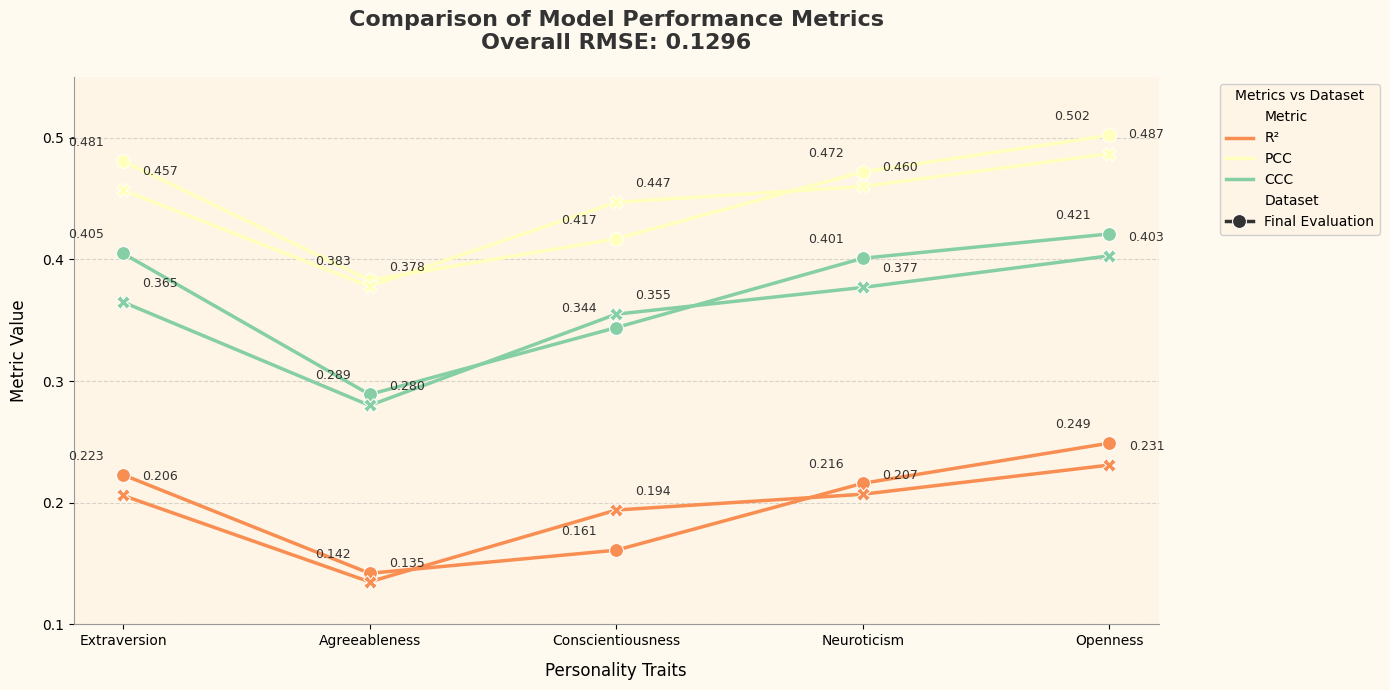

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Данные
traits = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']
metrics = ['R²', 'PCC', 'CCC']

# Первый набор результатов (Final Evaluation)
results1 = {
    'R²': [0.223, 0.142, 0.161, 0.216, 0.249],
    'PCC': [0.481, 0.383, 0.417, 0.472, 0.502],
    'CCC': [0.405, 0.289, 0.344, 0.401, 0.421]
}

# Второй набор результатов (r2, pcc, ccc)
results2 = {
    'R²': [0.206, 0.135, 0.194, 0.207, 0.231],
    'PCC': [0.457, 0.378, 0.447, 0.460, 0.487],
    'CCC': [0.365, 0.280, 0.355, 0.377, 0.403]
}

# Создаем DataFrame для обоих наборов
df1 = pd.DataFrame(results1)
df1['Trait'] = traits
df1['Dataset'] = 'Final Evaluation'

df2 = pd.DataFrame(results2)
df2['Trait'] = traits
df2['Dataset'] = 'Comparison Set'

df = pd.concat([df1, df2]).melt(id_vars=['Trait', 'Dataset'], 
                               value_vars=metrics,
                               var_name='Metric',
                               value_name='Value')

# Настройка стиля "sunset"
plt.style.use('default')
sns.set_palette(sns.color_palette("Spectral", n_colors=len(metrics)))
plt.rcParams['axes.facecolor'] = '#FFF5E6'  # Цвет фона

# Создаем фигуру
plt.figure(figsize=(14, 7))

# График с линиями
ax = sns.lineplot(data=df, x='Trait', y='Value', hue='Metric', 
                 style='Dataset', markers=True, dashes=False,
                 linewidth=2.5, markersize=10, err_style=None)

# Настройки оформления
plt.title('Comparison of Model Performance Metrics\nOverall RMSE: 0.1296', 
         fontsize=16, pad=20, fontweight='bold', color='#333333')
plt.xlabel('Personality Traits', fontsize=12, labelpad=10)
plt.ylabel('Metric Value', fontsize=12, labelpad=10)
plt.ylim(0.1, 0.55)

# Добавляем аннотации для Final Evaluation
for i, trait in enumerate(traits):
    for j, metric in enumerate(metrics):
        val = results1[metric][i]
        ax.text(i-0.15, val+0.01, f'{val:.3f}', 
               ha='center', va='bottom', fontsize=9, color='#333333')

# Добавляем аннотации для Comparison Set
for i, trait in enumerate(traits):
    for j, metric in enumerate(metrics):
        val = results2[metric][i]
        ax.text(i+0.15, val+0.01, f'{val:.3f}', 
               ha='center', va='bottom', fontsize=9, color='#333333')

# Легенда
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:6], labels[:6], title='Metrics vs Dataset',
          bbox_to_anchor=(1.05, 1), loc='upper left',
          frameon=True, framealpha=0.9)

# Сетка
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Улучшаем оси
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#999999')
ax.spines['bottom'].set_color('#999999')

# Солнечные эффекты
ax.set_facecolor('#FFF5E6')
plt.gcf().set_facecolor('#FFFAF0')

# Сохраняем и показываем
plt.tight_layout()
plt.savefig('metrics_comparison_sunset.png', dpi=300, bbox_inches='tight', facecolor='#FFFAF0')
plt.show()

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class xLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # вход и скрытое состояние для 4 гейтов
        self.x2h = nn.Linear(input_size, 4 * hidden_size)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size)

        # адаптивный forget bias
        self.forget_bias = nn.Parameter(torch.ones(hidden_size))

    def forward(self, x, hx):
        h, c = hx
        gates = self.x2h(x) + self.h2h(h)
        i, f, o, u = gates.chunk(4, dim=1)

        i = torch.sigmoid(i)
        f = torch.sigmoid(f + self.forget_bias)
        o = torch.sigmoid(o)
        u = torch.tanh(u)

        c_new = f * c + i * u
        h_new = o * torch.tanh(c_new)
        return h_new, c_new

class xLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super().__init__()
        self.layers = nn.ModuleList([
            xLSTMCell(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])

    def forward(self, x):
        # x: [B, T, D]
        B, T, _ = x.size()
        h = [torch.zeros(B, layer.hidden_size, device=x.device) for layer in self.layers]
        c = [torch.zeros(B, layer.hidden_size, device=x.device) for layer in self.layers]

        outputs = []
        for t in range(T):
            inp = x[:, t]
            for i, layer in enumerate(self.layers):
                h[i], c[i] = layer(inp, (h[i], c[i]))
                inp = h[i]
            outputs.append(inp.unsqueeze(1))

        return torch.cat(outputs, dim=1)  # [B, T, H]


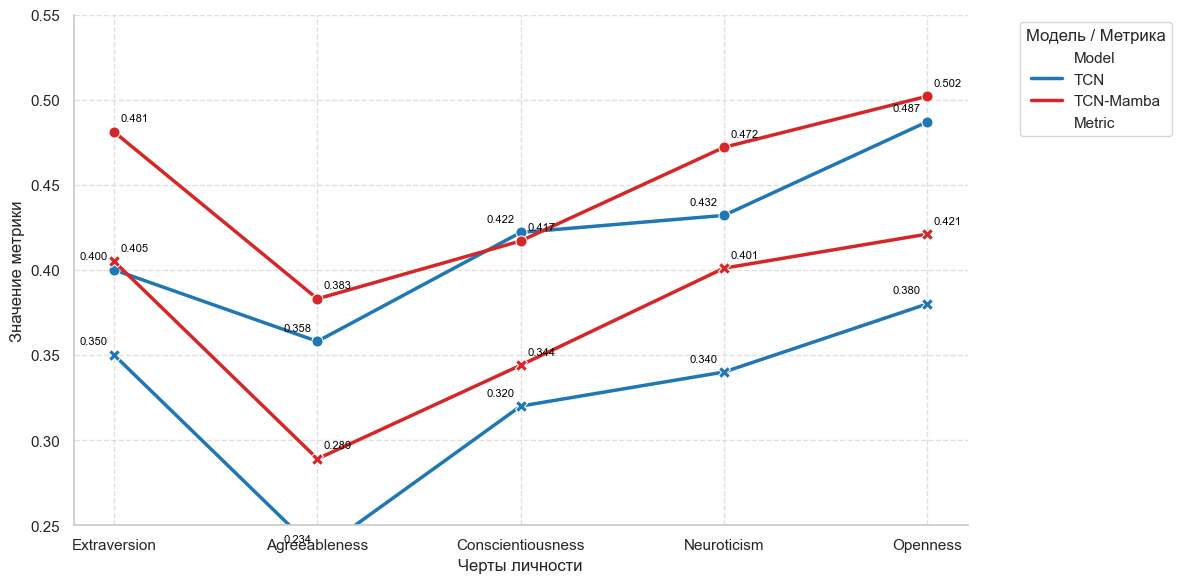

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Данные
traits = ['Extraversion', 'Agreeableness', 'Conscientiousness', 'Neuroticism', 'Openness']
metrics = ['PCC', 'CCC']  # R² убрана из списка метрик

# Результаты для TCN и TCN_Mamba
results_tcn_mamba  = {
    'R²': [0.223, 0.142, 0.161, 0.216, 0.249],
    'PCC': [0.481, 0.383, 0.417, 0.472, 0.502],
    'CCC': [0.405, 0.289, 0.344, 0.401, 0.421]
}

results_tcn = {
    'R²': [0.194, 0.12, 0.18765, 0.1985, 0.23],
    'PCC': [0.400, 0.358, 0.422, 0.432, 0.4870],
    'CCC': [0.35, 0.234, 0.320, 0.340, 0.380]
}

# Создаем DataFrame без R²
df_tcn = pd.DataFrame({k: v for k, v in results_tcn.items() if k != 'R²'})
df_tcn['Trait'] = traits
df_tcn['Model'] = 'TCN'

df_tcn_mamba = pd.DataFrame({k: v for k, v in results_tcn_mamba.items() if k != 'R²'})
df_tcn_mamba['Trait'] = traits
df_tcn_mamba['Model'] = 'TCN-Mamba'

df = pd.concat([df_tcn, df_tcn_mamba]).melt(id_vars=['Trait', 'Model'],
                                           value_vars=metrics,
                                           var_name='Metric',
                                           value_name='Value')

# Цветовая палитра
palette = {'TCN': '#1f77b4', 'TCN-Mamba': '#d62728'}

# Настройка стиля
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Линейный график
ax = sns.lineplot(data=df, x='Trait', y='Value', hue='Model', style='Metric',
                  markers=True, dashes=False, linewidth=2.5, markersize=8,
                  palette=palette, err_style=None)

# Заголовок и метки
# plt.title('Сравнение метрик: TCN vs TCN-Mamba (без R²)', fontsize=14, pad=15)
plt.xlabel('Черты личности', fontsize=12)
plt.ylabel('Значение метрики', fontsize=12)
plt.ylim(0.25, 0.55)  # Можно скорректировать под данные без R²

# Аннотации значений на графике
for i, trait in enumerate(traits):
    for model_data, offset, label in zip(
        [results_tcn, results_tcn_mamba],
        [-0.1, 0.1],
        ['TCN', 'TCN-Mamba']
    ):
        for j, metric in enumerate(metrics):
            val = model_data[metric][i]
            ax.text(i + offset, val + 0.005, f'{val:.3f}', ha='center', va='bottom',
                    fontsize=8, color='black')

# Легенда
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:4], labels[:4], title='Модель / Метрика',
           bbox_to_anchor=(1.05, 1), loc='upper left')

# Сетка и границы
ax.grid(True, linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Расположение и сохранение
plt.tight_layout()
plt.savefig('metrics_comparison_tcn_vs_tcn_mamba_no_r2.png', dpi=300, bbox_inches='tight')
plt.show()

In [101]:
class BigFiveDataset290Avg(Dataset):
    def __init__(self, X, y, x_mean=None, x_std=None, y_mean=None, y_std=None, train=False):
        self.train = train

        # Базовые динамические признаки
        velocity = np.diff(X, axis=1, prepend=X[:, :1, :])
        acceleration = np.diff(velocity, axis=1, prepend=velocity[:, :1, :])
        jerk = np.diff(acceleration, axis=1, prepend=acceleration[:, :1, :])
        jerk_rms = np.sqrt(np.mean(jerk ** 2, axis=(1, 2), keepdims=True))
        kinetic_energy = np.sum(velocity ** 2, axis=2, keepdims=True)
        smoothness = 1.0 / (np.sum(np.abs(jerk), axis=(1, 2), keepdims=True) + 1e-6)

        jerk_rms_rep = np.repeat(jerk_rms, X.shape[1], axis=1)
        smoothness_rep = np.repeat(smoothness, X.shape[1], axis=1)

        def pairwise_distance(X, i, j):
            xi = X[:, :, i*3:(i+1)*3]
            xj = X[:, :, j*3:(j+1)*3]
            return np.linalg.norm(xi - xj, axis=2, keepdims=True)

        wrist_dist = pairwise_distance(X, 15, 20)
        elbow_dist = pairwise_distance(X, 13, 18)
        knee_dist = pairwise_distance(X, 26, 31)

        def compute_symmetry(X, left_idxs, right_idxs):
            diffs = []
            for l, r in zip(left_idxs, right_idxs):
                left = X[:, :, l*3:(l+1)*3]
                right = X[:, :, r*3:(r+1)*3]
                diffs.append(np.abs(left - right))
            return np.concatenate(diffs, axis=2)

        symmetry = compute_symmetry(X, [15, 13, 26], [20, 18, 31])

        def compute_joint_angles(X, a, b, c):
            A = X[:, :, a*3:(a+1)*3]
            B = X[:, :, b*3:(b+1)*3]
            C = X[:, :, c*3:(c+1)*3]
            BA = A - B
            BC = C - B
            dot = np.sum(BA * BC, axis=2)
            norm_product = np.linalg.norm(BA, axis=2) * np.linalg.norm(BC, axis=2)
            cos_angle = np.clip(dot / (norm_product + 1e-6), -1.0, 1.0)
            angle = np.arccos(cos_angle)
            return angle[:, :, np.newaxis]

        left_elbow_angle = compute_joint_angles(X, 11, 13, 15)
        right_elbow_angle = compute_joint_angles(X, 16, 18, 20)

        # Собираем расширенные признаки
        X_aug = np.concatenate([
            X, velocity, acceleration, jerk,
            jerk_rms_rep, kinetic_energy, smoothness_rep,
            wrist_dist, elbow_dist, knee_dist,
            symmetry, left_elbow_angle, right_elbow_angle
        ], axis=2)

        # Нормализация
        if x_mean is not None and x_std is not None:
            X_aug = (X_aug - x_mean) / (x_std + 1e-6)
        if y_mean is not None and y_std is not None:
            y = (y - y_mean) / (y_std + 1e-6)

        # 🟢 Среднее по времени
        X_avg = X_aug.mean(axis=1)  # (N, C)

        self.X = torch.tensor(X_avg, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]

        if self.train:
            if torch.rand(1) > 0.8:
                noise = torch.randn_like(x) * 0.01
                x = x + noise

        return x, y


In [102]:
# Загрузка данных
train_data = np.load(train_path)
X_train = remove_leg_channels(train_data['X'])
y_train = train_data['y']

# Создание датасета без нормализации, чтобы сначала получить полный X_aug
temp_dataset = BigFiveDataset290(X_train, y_train)
X_aug_full = temp_dataset.X.numpy()  # (N, T, C)

# Статистики
x_mean = X_aug_full.mean(axis=(0, 1), keepdims=True)
x_std = X_aug_full.std(axis=(0, 1), keepdims=True)
y_mean = y_train.mean(axis=0, keepdims=True)
y_std = y_train.std(axis=0, keepdims=True)

# Датасет со средними признаками (N, C)
dataset_avg = BigFiveDataset290Avg(X_train, y_train, x_mean, x_std, y_mean, y_std)

# Получение усреднённых признаков и целей
X_avg = dataset_avg.X.numpy()  # (N, C)
y = dataset_avg.y.numpy()      # (N, 5) — Big Five

print("X_avg.shape:", X_avg.shape)
print("y.shape:", y.shape)


X_avg.shape: (3118, 290)
y.shape: (3118, 5)


In [103]:
def generate_feature_names290(num_joints=23):
    feature_names = []

    # Список точек, которые мы оставляем (0–22)
    joints = list(range(num_joints))  # от 0 до 22

    # 1. Исходные координаты: x_j0, y_j0, z_j0, ..., x_j22, y_j22, z_j22
    for j in joints:
        feature_names += [f'x_{j}', f'y_{j}', f'z_{j}']

    # 2. Скорость: vx_j0, vy_j0, vz_j0, ...
    for j in joints:
        feature_names += [f'vx_{j}', f'vy_{j}', f'vz_{j}']

    # 3. Ускорение: ax_j0, ay_j0, az_j0, ...
    for j in joints:
        feature_names += [f'ax_{j}', f'ay_{j}', f'az_{j}']

    # 4. Джерк / рывок: jx_j0, jy_j0, jz_j0, ...
    for j in joints:
        feature_names += [f'jx_{j}', f'jy_{j}', f'jz_{j}']

    # 5. Глобальные статистики (повторяются по времени)
    feature_names += ['jerk_rms']
    feature_names += ['kinetic_energy']
    feature_names += ['smoothness']

    # 6. Парные расстояния (между ключевыми точками)
    feature_names += ['wrist_distance']   # между j15 и j20
    feature_names += ['elbow_distance']   # между j13 и j18
    feature_names += ['knee_distance']    # между j26 и j31 — но они удалены

    # 7. Симметрия между левой и правой стороной
    symmetry_pairs = [(15, 20), (13, 18)]  # j26 и j31 уже нет
    for l, r in symmetry_pairs:
        feature_names += [f'symmetry_{l}_{r}_dx', f'symmetry_{l}_{r}_dy', f'symmetry_{l}_{r}_dz']

    # 8. Углы суставов
    feature_names += ['left_elbow_angle_rad']   # между j11, j13, j15
    feature_names += ['right_elbow_angle_rad']  # между j16, j18, j20

    return feature_names

# Создаём список имён фичей
feature_names = generate_feature_names290()

# Вывод количества и первых фичей
print(f"Количество фичей: {len(feature_names)}")
print("Первые 10 фичей:")
print(feature_names[:10])

Количество фичей: 290
Первые 10 фичей:
['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'x_2', 'y_2', 'z_2', 'x_3']


In [ ]:
import shap
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_avg, y)

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_avg)

shap.summary_plot(shap_values, X_avg, plot_type="bar")


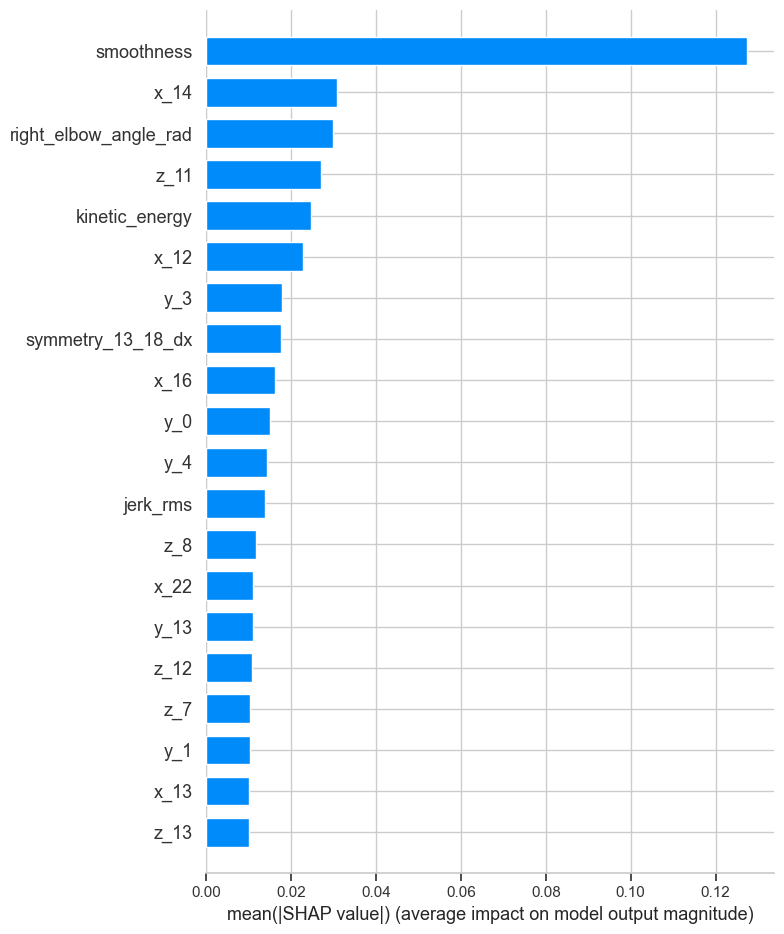

In [104]:
import shap
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Импорт feature_names
feature_names = generate_feature_names290()

# Проверим согласованность
assert X_avg.shape[1] == len(feature_names), "Число фичей не совпадает с длиной feature_names!"

# Обучаем модель для одной цели (например, первая черта личности: Extraversion)
target_idx = 0
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_avg, y[:, target_idx])

# SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_avg)

# Построение графика с названиями признаков
shap.summary_plot(shap_values, X_avg, feature_names=feature_names, plot_type="bar")


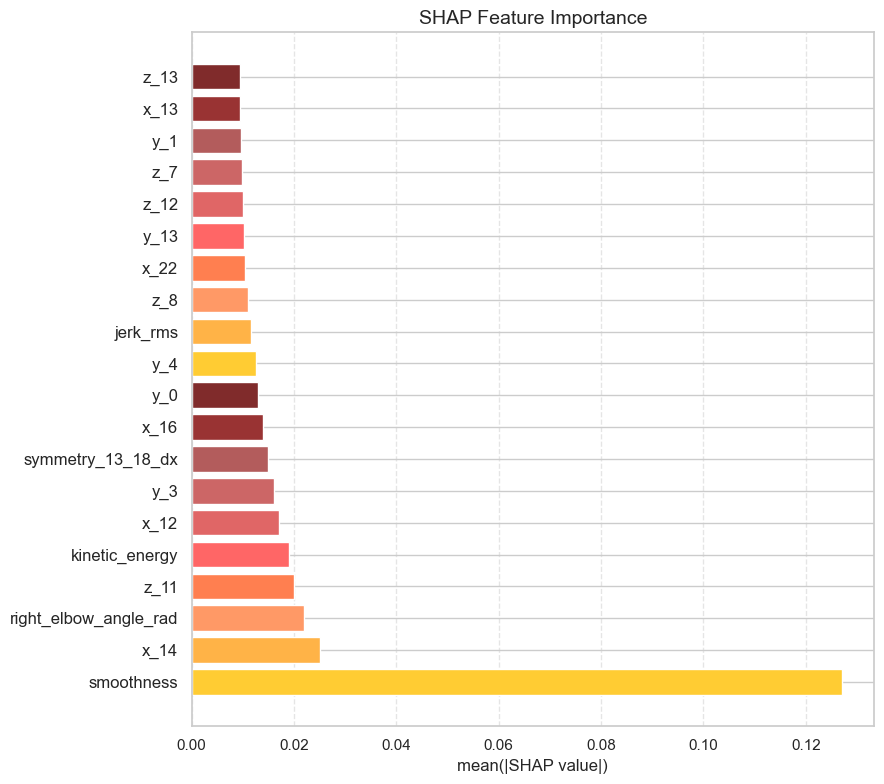

In [111]:
import matplotlib.pyplot as plt

features = [
    'smoothness', 'x_14', 'right_elbow_angle_rad', 'z_11', 'kinetic_energy',
    'x_12', 'y_3', 'symmetry_13_18_dx', 'x_16', 'y_0',
    'y_4', 'jerk_rms', 'z_8', 'x_22', 'y_13',
    'z_12', 'z_7', 'y_1', 'x_13', 'z_13'
]

shap_values = [
    0.127, 0.025, 0.022, 0.020, 0.019,
    0.017, 0.016, 0.015, 0.014, 0.013,
    0.0125, 0.0115, 0.011, 0.0105, 0.0102,
    0.0101, 0.0098, 0.0096, 0.0095, 0.0094
]

# Цвета "sunset"
# sunset_colors = [
#     "#ffcc33", "#ffb347", "#ff9966", "#ff7f50", "#ff6666",
#     "#e06666", "#cc6666", "#b35c5c", "#993333", "#802b2b",
#     "#ffcc33", "#ffb347", "#ff9966", "#ff7f50", "#ff6666",
#     "#e06666", "#cc6666", "#b35c5c", "#993333", "#802b2b",
# ]

# Отрисовка
plt.figure(figsize=(9, 8))
plt.barh(range(len(features)), shap_values[::-1], color=sunset_colors[::-1])
plt.yticks(range(len(features)), features[::-1], fontsize=12)
plt.xlabel("mean(|SHAP value|)", fontsize=12)
plt.title("SHAP Feature Importance", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [110]:
sunset_colors = [
    "#ffcc33",  # самый "лёгкий" (низкое значение SHAP)
    "#ffb347",
    "#ff9966",
    "#ff7f50",
    "#ff6666",
    "#e06666",
    "#cc6666",
    "#b35c5c",
    "#993333",
    "#802b2b",  # самый "тяжёлый" (высокое значение SHAP)
    "#ffcc33",
    "#ffb347",
    "#ff9966",
    "#ff7f50",
    "#ff6666",
    "#e06666",
    "#cc6666",
    "#b35c5c",
    "#993333",
    "#802b2b"
]